
# Implementing a Toy Graph Neural Network for Weather Forecasting

## Introduction
### Overview
This notebook contains a toy-GNN for predicting the weather using historical data.  
The goal is to train a model to learn a graph representation of the Earth's weather state and make predictions based on that representation.

Nodes in this graph represent individual grid points on the Earth's surface.
The Node features are regularly sampled (6-hourly), multivariate timeseries that represent historical weather data for each grid point,  
like temperature, pressure, humidity, wind speed and direction.

The prediction task is to forecast the next weather state 6 hours in the future for each grid point in the graph.

### Data
The [WeatherBench Dataset](https://github.com/pangeo-data/WeatherBench) used in this project is historical reanalysis weather data from ERA5 up to present day.   
It contains gridded weather data at multiple resolutions, with the toy model using a 5.625 degree resolution (32x64 grid points, 2048 total points).

The data includes the following features for each grid point:

Surface variables:
- Temperature at 2m: Surface air temperature
- Mean sea level pressure: Atmospheric pressure at sea level
- U-component of wind at 10m: Eastward wind velocity
- V-component of wind at 10m: Northward wind velocity

Atmospheric variables at 250hPa, 500hPa, and 1000hPa:
- Geopotential: Height of the pressure level at 250hPa, 500hPa, and 1000hPa
- Temperature: Air temperature at 250hPa, 500hPa, and 1000hPa
- U-component of wind: Eastward wind velocity at 250hPa, 500hPa, and 1000hPa
- V-component of wind: Northward wind velocity at 250hPa, 500hPa, and 1000hPa




___
## Organization
### Prelude

In [ ]:
# uncomment if needed
# !pip install torch torch-geometric
# !pip install xarray netcdf4 zarr gcsfs dask
# !pip install matplotlib seaborn numpy pandas scikit-learn
# !pip install tqdm ipywidgets
# !pip install pathlib

In [ ]:
from IPython.display import display, HTML, clear_output
from datetime import datetime
from ipywidgets import IntProgress
from os.path import isfile, join
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Dataset, Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool, global_max_pool
from tqdm import tqdm
from tqdm.notebook import tqdm
import ipywidgets as widgets
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import xarray as xr

___
### Configuration
The entire notebook is configured via the `Config` class, which allows you to set various parameters for the model, data loading, and training process.  
You can modify the configuration parameters to suit your needs, such as changing the number of epochs, batch size, learning rate, and more.

In [ ]:
class Config:
    # Dataset
    BASE_URL = "gs://weatherbench2/datasets/era5/"
    DATASET = "1959-2023_01_10-6h-64x32_equiangular_conservative.zarr"

    OUTPUT_DIR = Path("./data")
    RAW_DIR = OUTPUT_DIR / "raw"
    PROCESSED_DIR = OUTPUT_DIR / "processed"
    MODEL_DIR = Path("./models")

    # roughly 80 / 20 split
    TRAIN_YEARS = range(1979, 2014)
    TEST_YEARS = range(2014, 2023) 

    # Selected Features
    SURFACE_VARS = [
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        '2m_temperature',
        'mean_sea_level_pressure',
    ]
    ATMOSPHERIC_VARS = [
        'geopotential',
        'temperature',
        'u_component_of_wind',
        'v_component_of_wind',
    ]
    PRESSURE_LEVELS = [1000, 500, 250] # reduced to 3 from 13
    
    # Training parameters
    NUM_EPOCHS = 3
    TRAIN_BATCH_SIZE = 32
    LEARNING_RATE = 1e-3

    # Model parameters
    HIDDEN_CHANNELS = 256
    NUM_LAYERS = 6
    # TODO: Add more model parameters and evaluate perfomance differences
    # AGGREGATION = 'mean'  # Options: 'mean', 'max', 'sum'
    # POOLING = 'mean'  # Options: 'mean', 'max', 'sum'

___
## Handling Data

### Download

1. Setup necessary directories
2. Download training data ~7GB [1979-2014)
3. Download test data ~2GB [2014-2023)

In [4]:
def setup_directories():
    (Config.OUTPUT_DIR).mkdir(exist_ok=True)
    (Config.RAW_DIR).mkdir(exist_ok=True)
    (Config.PROCESSED_DIR).mkdir(exist_ok=True)
    (Config.MODEL_DIR).mkdir(exist_ok=True)

def download_era5_subset(year_range, output_path):
    print(f"Loading ERA5 data for years {list(year_range)}...")
    
    ds = xr.open_zarr(f"{Config.BASE_URL}{Config.DATASET}")
    
    print(f"Full dataset shape: {ds.dims}")
    print(f"Available variables: {len(list(ds.data_vars))}")
    
    start_date = f"{min(year_range)}-01-01"
    end_date = f"{max(year_range)}-12-31"
    ds_filtered = ds.sel(time=slice(start_date, end_date))
    
    print(f"Filtered time range: {ds_filtered.time.values[0]} to {ds_filtered.time.values[-1]}")
    print(f"Time steps: {len(ds_filtered.time)}")
    
    surface_vars = [var for var in Config.SURFACE_VARS if var in ds_filtered.data_vars]
    atmospheric_vars = [var for var in Config.ATMOSPHERIC_VARS if var in ds_filtered.data_vars]
    
    print(f"Selected surface variables: {surface_vars}")
    print(f"Selected atmospheric variables: {atmospheric_vars}")
    
    surface_data = {}
    for var in surface_vars:
        print(f"Processing surface variable: {var}")
        surface_data[var] = ds_filtered[var]
    
    atmospheric_data = {}
    available_levels = ds_filtered.level.values
    selected_levels = [level for level in Config.PRESSURE_LEVELS if level in available_levels]
    
    print(f"Available pressure levels: {available_levels}")
    print(f"Selected pressure levels: {selected_levels}")
    
    for var in atmospheric_vars:
        print(f"Processing atmospheric variable: {var}")
        atmospheric_data[var] = ds_filtered[var].sel(level=selected_levels)
    
    # Combine into single dataset
    combined_data = {**surface_data, **atmospheric_data}
    ds_subset = xr.Dataset(combined_data)
    
    # Add coordinates that might be missing
    ds_subset = ds_subset.assign_coords({
        'latitude': ds_filtered.latitude,
        'longitude': ds_filtered.longitude,
        'time': ds_filtered.time
    })
    
    if len(selected_levels) > 0:
        ds_subset = ds_subset.assign_coords({'level': selected_levels})
    
    print(f"Final subset shape: {ds_subset.dims}")
    
    print(f"Saving to {output_path}...")
    ds_subset.to_netcdf(
        output_path,
        mode='w',
        compute=True,
        engine='netcdf4'
    )

In [5]:

print("Setting up directories...")
setup_directories()



print("\nDownloading training data...")
train_raw_path = Config.RAW_DIR / "train_data.nc"
if not train_raw_path.exists():
    download_era5_subset(Config.TRAIN_YEARS, train_raw_path)
    ds_train = xr.open_dataset(train_raw_path)
else:
    print("\tLoading existing training data...")
    ds_train = xr.open_dataset(train_raw_path)



print("\nDownloading test data...")
test_raw_path = Config.RAW_DIR / "test_data.nc"
if not test_raw_path.exists():
    download_era5_subset(Config.TEST_YEARS, test_raw_path)
    ds_test = xr.open_dataset(test_raw_path)
else:
    print("\tLoading existing test data...")
    ds_test = xr.open_dataset(test_raw_path)

Setting up directories...

	Loading existing training data...

	Loading existing test data...


___
### Preprocess

#### Validation
We are working with ERA5 reanalysis data, which is a gridded dataset with regular sampling.  
The data is expected to not contain NaN values and expected to be clean, so we chost to just skip validation.

#### Normalization
In order to not have large values in the dataset completely dominate the loss function, we normalize the data.  
The normalization is done by subtracting the mean and dividing by the standard deviation for each feature across the entire training dataset.  
This ensures that each feature has a mean of 0 and a standard deviation of 1.

Later, during inference, the reverse is applied to the predicted values to get values in the in the initial ranges.

In [ ]:
Config.PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
norm_stats_path = Config.PROCESSED_DIR / "norm_stats.json"

print("Calculating normalization statistics from the training set...")
norm_path = Config.PROCESSED_DIR / "norm_stats.json"
if not norm_path.exists():
    norm_stats = {}

    print("\tProcessing Surface Variables...")
    for var in Config.SURFACE_VARS:
        if var not in ds_train:
            print(f"Warning: Surface variable '{var}' not found. Skipping.")
            continue
        
        mean_val = ds_train[var].mean().item()
        std_val = ds_train[var].std().item()
        
        norm_stats[var] = {'mean': mean_val, 'std': std_val}
        print(f"- {var}: Mean={mean_val:.2f}, Std={std_val:.2f}")

    print("\tProcessing Atmospheric Variables...")
    for var in Config.ATMOSPHERIC_VARS:
        if var not in ds_train:
            print(f"Warning: Atmospheric variable '{var}' not found. Skipping.")
            continue
            
        for level in Config.PRESSURE_LEVELS:
            var_level_key = f"{var}_{level}"
            
            data_at_level = ds_train[var].sel(level=level)
            
            mean_val = data_at_level.mean().item()
            std_val = data_at_level.std().item()
            
            # Handle cases where std dev is zero (constant value)
            if std_val < 1e-6:
                print(f"Warning: Std dev for {var_level_key} is near zero. Setting to 1.0 to avoid division by zero.")
                std_val = 1.0

            norm_stats[var_level_key] = {'mean': mean_val, 'std': std_val}
            print(f"- {var_level_key}: Mean={mean_val:.2f}, Std={std_val:.2f}")


    print(f"\tSaving normalization stats to: {norm_stats_path}")
    with open(norm_stats_path, 'w') as f:
        json.dump(norm_stats, f, indent=4)

    print("\tNormalization statistics calculated and saved")
else:
    print("\tLoading existing test data...")
    norm_stats = {}
    with open(norm_stats_path, 'r') as f:
        norm_stats = json.load(f)

print("\nNormalization statistics:")
for key, stats in norm_stats.items():
    print(f"{key}: Mean={stats['mean']:.2f}, Std={stats['std']:.2f}")

Calculating normalization statistics from the training set...
	Loading existing test data...

Normalization statistics:
10m_u_component_of_wind: Mean=-0.06, Std=5.06
10m_v_component_of_wind: Mean=0.19, Std=4.31
2m_temperature: Mean=278.53, Std=20.93
mean_sea_level_pressure: Mean=100955.13, Std=1309.48
geopotential_1000: Mean=737.42, Std=1055.76
geopotential_500: Mean=54112.08, Std=3334.15
geopotential_250: Mean=101213.74, Std=5509.74
temperature_1000: Mean=281.02, Std=16.97
temperature_500: Mean=252.93, Std=12.98
temperature_250: Mean=222.73, Std=8.40
u_component_of_wind_1000: Mean=-0.04, Std=5.60
u_component_of_wind_500: Mean=6.58, Std=11.28
u_component_of_wind_250: Mean=13.39, Std=17.11
v_component_of_wind_1000: Mean=0.19, Std=4.80
v_component_of_wind_500: Mean=-0.03, Std=8.62
v_component_of_wind_250: Mean=-0.03, Std=12.69


___

### Visualization

In [34]:
print("_" * 120)
print("Training dataset info:")
print(ds_train)
print(ds_test)
print("_" * 120)
print(ds_train.dims)

# print("\nMaximum and minimum values for each variable in training data:")
# for var in ds_train.data_vars:
#     print(f"{var}: min={ds_train[var].min().item():.3f}, max={ds_train[var].max().item():.3f}")

________________________________________________________________________________________________________________________
Training dataset info:
<xarray.Dataset> Size: 7GB
Dimensions:                  (time: 51136, longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                 (latitude) float64 256B -87.19 -81.56 ... 87.19
  * longitude                (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * time                     (time) datetime64[ns] 409kB 1979-01-01 ... 2013-...
  * level                    (level) int64 24B 1000 500 250
Data variables:
    10m_u_component_of_wind  (time, longitude, latitude) float32 419MB ...
    10m_v_component_of_wind  (time, longitude, latitude) float32 419MB ...
    2m_temperature           (time, longitude, latitude) float32 419MB ...
    mean_sea_level_pressure  (time, longitude, latitude) float32 419MB ...
    geopotential             (time, level, longitude, latitude) float32 1GB ...
    temperature              (time, leve

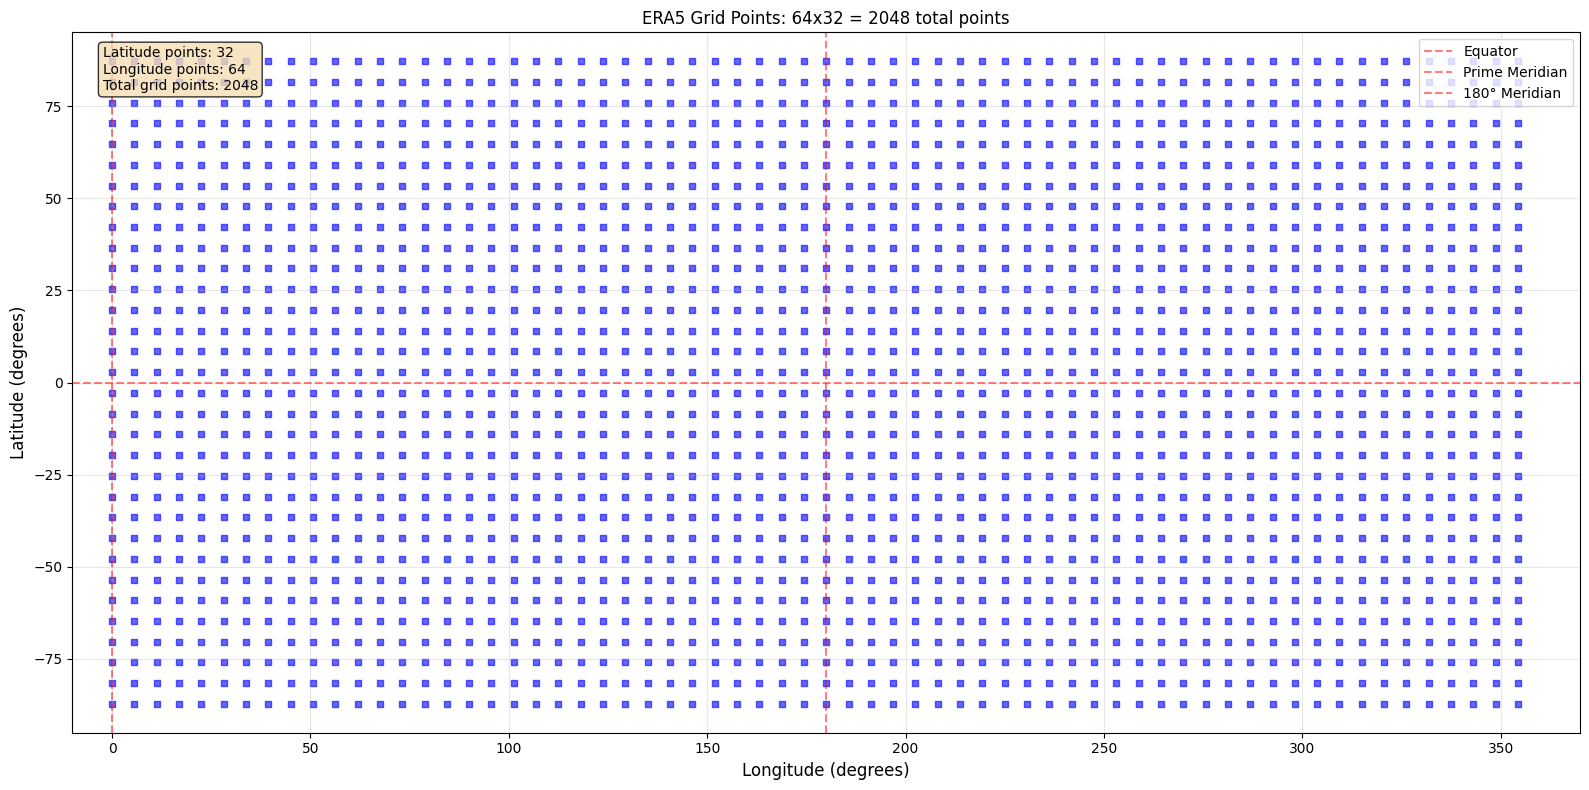

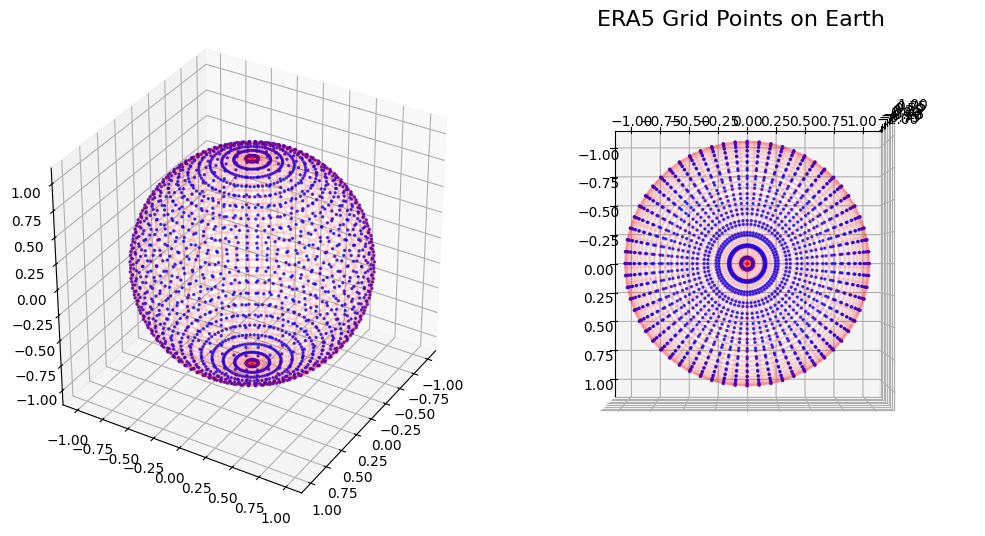

In [35]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_grid():
    _, ax = plt.subplots(1, 1, figsize=(16, 8))

    lats = ds_train.latitude.values
    lons = ds_train.longitude.values

    num_lat_points = len(lats)
    num_lon_points = len(lons)

    lon_grid, lat_grid = np.meshgrid(lons, lats)
    _ = ax.scatter(lon_grid, lat_grid, c='blue', s=20, alpha=0.6, marker='s')
    ax.grid(True, alpha=0.3)

    # Set labels and title
    ax.set_xlabel('Longitude (degrees)', fontsize=12)
    ax.set_ylabel('Latitude (degrees)', fontsize=12)
    ax.set_title(f'ERA5 Grid Points: {num_lon_points}x{num_lat_points} = {num_lat_points * num_lon_points} total points')

    # Set axis limits
    ax.set_xlim(-10, 370)
    ax.set_ylim(-95, 95)

    ax.text(0.02, 0.98, f'Latitude points: {num_lat_points}\nLongitude points: {num_lon_points}\n'
                        f'Total grid points: {num_lat_points * num_lon_points}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Add geographic reference lines
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Equator')
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Prime Meridian')
    ax.axvline(x=180, color='red', linestyle='--', alpha=0.5, label='180° Meridian')

    # Add legend
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def visualize_grid_on_sphere():
    # Get coordinates
    lats = ds_train.latitude.values
    lons = ds_train.longitude.values
    
    # Create meshgrid
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    # Convert to radians
    lat_rad = np.radians(lat_grid)
    lon_rad = np.radians(lon_grid)
    
    # Convert spherical coordinates to Cartesian coordinates (Earth radius = 1)
    x = np.cos(lat_rad) * np.cos(lon_rad)
    y = np.cos(lat_rad) * np.sin(lon_rad)
    z = np.sin(lat_rad)
    
    # Create 3D plot
    fig = plt.figure(figsize=(15, 5))
    
    # Create two subplots for different viewing angles
    angles = [(33, 31, "Angled View"),(90, 0, "North Pole View")] 
    
    for i, (elev, azim, title) in enumerate(angles):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        # Plot grid points
        ax.scatter(x, y, z, c='blue', s=2, alpha=0.7)
        
        # Create a wireframe sphere for reference
        u = np.linspace(0, 2 * np.pi, 50)
        v = np.linspace(0, np.pi, 50)
        x_sphere = np.outer(np.cos(u), np.sin(v))
        y_sphere = np.outer(np.sin(u), np.sin(v))
        z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
        
        ax.plot_wireframe(x_sphere, y_sphere, z_sphere, alpha=0.1, color='red')
        
        # Set viewing angle
        ax.view_init(elev=elev, azim=azim)
        
        # Make axes equal
        ax.set_box_aspect([1.,1.,1.])
    
    plt.tight_layout()
    plt.suptitle(f'ERA5 Grid Points on Earth', 
                 fontsize=16, y=1.02)
    plt.show()

visualize_grid()
visualize_grid_on_sphere()

___
## Creating the Graph Neural Network
### Creating the Graph

In [ ]:
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

class WeatherGraphStructure:
    def __init__(self, ds, k_neighbors=8):
        self.lats = ds.latitude.values  # 32 points
        self.lons = ds.longitude.values  # 64 points
        self.num_nodes = len(self.lats) * len(self.lons)  # 2048
        self.k_neighbors = k_neighbors
        
        self.positions = self._create_positions()
        self.edge_index = self._create_connectivity()
    
    def _create_positions(self):
        positions = []
        for lat in self.lats:
            for lon in self.lons:
                positions.append([lat, lon])
        return torch.tensor(positions, dtype=torch.float32)
    
    # TODO: compare to haversine distance
    def _create_connectivity_euclidean(self):
        nbrs = NearestNeighbors(n_neighbors=self.k_neighbors + 1, metric='euclidean')
        nbrs.fit(self.positions.numpy())
        _, indices = nbrs.kneighbors(self.positions.numpy())
        
        edge_list = []
        for i, neighbors in enumerate(indices):
            for neighbor in neighbors[1:]:  # Skip self (first neighbor)
                edge_list.append([i, neighbor])
        
        edge_array = np.array(edge_list)
        edge_index = torch.tensor(edge_array, dtype=torch.long).t().contiguous()
        return edge_index

    def _create_connectivity(self):
        positions_rad = torch.deg2rad(self.positions)

        # use haversine distance for globe
        nbrs = NearestNeighbors(n_neighbors=self.k_neighbors + 1, metric='haversine')
        nbrs.fit(positions_rad.numpy())
        _, indices = nbrs.kneighbors(positions_rad.numpy())

        edge_list = []
        for i, neighbors in enumerate(indices):
            for neighbor in neighbors[1:]:
                edge_list.append([i, neighbor])

        edge_array = np.array(edge_list)
        edge_index = torch.tensor(edge_array, dtype=torch.long).t().contiguous()
        return edge_index
    
    def extract_features(self, ds, time_idx, norm_stats=None):
        node_features = []
        
        # Surface variables - shape: (time, lon, lat) -> flatten to (num_nodes,)
        for var in Config.SURFACE_VARS:
            if var in ds.data_vars:
                # Get data at time_idx and flatten in correct order (lat, lon)
                data = ds[var].isel(time=time_idx).values.T.flatten()
                
                # Normalize if stats provided
                if norm_stats and var in norm_stats:
                    data = (data - norm_stats[var]['mean']) / norm_stats[var]['std']
                
                node_features.append(data)
        
        # Atmospheric variables - shape: (time, level, lon, lat) 
        for var in Config.ATMOSPHERIC_VARS:
            if var in ds.data_vars:
                for level in Config.PRESSURE_LEVELS:
                    var_key = f"{var}_{level}"
                    data = ds[var].sel(level=level).isel(time=time_idx).values.T.flatten()
                    # normalize 
                    if norm_stats and var_key in norm_stats:
                        data = (data - norm_stats[var_key]['mean']) / norm_stats[var_key]['std']
                    
                    node_features.append(data)
        
        # Stack features: shape (num_nodes, num_features)
        features = torch.tensor(np.column_stack(node_features), dtype=torch.float32)
        
        return features
    
    def create_data_object(self, features):
        return Data(x=features, edge_index=self.edge_index, pos=self.positions)

### Creating Training Sequences

In [ ]:
from torch.utils.data import Dataset

class WeatherSequenceDataset(Dataset):
    def __init__(self, ds, graph_structure, norm_stats):
        self.ds = ds
        self.graph_structure = graph_structure
        self.norm_stats = norm_stats
        
        self.valid_indices = list(range(len(ds.time) - 1))
        # number of features per node
        self.num_features = len(Config.SURFACE_VARS) + len(Config.ATMOSPHERIC_VARS) * len(Config.PRESSURE_LEVELS)
        
    def __len__(self):
        return len(self.valid_indices)
    
    # extracts features for current and next time step
    def __getitem__(self, idx):
        time_idx = self.valid_indices[idx]
        
        current_features = self.graph_structure.extract_features(
            self.ds, time_idx, self.norm_stats
        )
        target_features = self.graph_structure.extract_features(
            self.ds, time_idx + 1, self.norm_stats  
        )
        
        return {
            'x': current_features,
            'y': target_features,
            'edge_index': self.graph_structure.edge_index,
            'pos': self.graph_structure.positions
        }

### Model Architecture

In [ ]:
class ToyWeatherGNN(nn.Module):
    def __init__(self, input_features, hidden_dim=256, num_layers=6):
        super().__init__()
        
        self.input_features = input_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.activation = nn.ReLU()
        
        # Input layer
        self.input = nn.Linear(input_features, hidden_dim)
        
        # GNN layers
        self.gnn_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        
        for _ in range(num_layers):
            self.gnn_layers.append(GCNConv(hidden_dim, hidden_dim))
            self.layer_norms.append(nn.LayerNorm(hidden_dim))
        
        # Output layer
        self.output = nn.Linear(hidden_dim, input_features)
        
    def forward(self, x, edge_index):
        x = self.input(x)
        x = self.activation(x)
        
        for gnn_layer, layer_norm in zip(self.gnn_layers, self.layer_norms):
            x = gnn_layer(x, edge_index)
            x = layer_norm(x)
            x = self.activation(x)
        
        x = self.output(x)
        
        return x

### Training


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch_geometric.loader import DataLoader as GeometricDataLoader
from torch_geometric.data import Batch

def collate_fn(batch_list):
    if len(batch_list) == 1:
        return batch_list[0]
    
    data_list = []
    for item in batch_list:
        from torch_geometric.data import Data
        data_obj = Data(
            x=item['x'],
            edge_index=item['edge_index'], 
            y=item['y'],
            pos=item['pos']
        )
        data_list.append(data_obj)
    
    batched = Batch.from_data_list(data_list)
    return {
        'x': batched.x,
        'edge_index': batched.edge_index,
        'y': batched.y,
        'pos': batched.pos,
        'batch': batched.batch
    }

def train_model():
    print("Loading normalization statistics...")
    with open(Config.PROCESSED_DIR / "norm_stats.json", 'r') as f:
        norm_stats = json.load(f)
    
    print("Creating graph structure...")
    graph_structure = WeatherGraphStructure(ds_train, k_neighbors=8)
    
    print("Creating datasets...")
    train_dataset = WeatherSequenceDataset(ds_train, graph_structure, norm_stats)
    test_dataset = WeatherSequenceDataset(ds_test, graph_structure, norm_stats)
    
    BATCH_SIZE = Config.TRAIN_BATCH_SIZE
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE, 
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )

    print("Creating model...")
    model = ToyWeatherGNN(
        input_features=train_dataset.num_features,
        hidden_dim=Config.HIDDEN_CHANNELS,
        num_layers=Config.NUM_LAYERS,
    )
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Optimier and loss function
    optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    criterion = nn.MSELoss()

    # Loss tracking arrays
    train_losses = []
    val_losses = []
    
    # Training loop
    num_epochs = Config.NUM_EPOCHS
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print('' + '-' * 80)
        # ----------------------------------------------------------------------------------
        # Training
        model.train()
        train_loss = 0
        num_batches = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch      {epoch+1}/{num_epochs}')
        
        for batch in progress_bar:
            # Move data to device
            x = batch['x'].to(device, non_blocking=True)
            y = batch['y'].to(device, non_blocking=True)
            edge_index = batch['edge_index'].to(device, non_blocking=True)
            
            # Set gradients to zero
            optimizer.zero_grad()
            
            # Forward pass
            pred = model(x, edge_index)
            loss = criterion(pred, y)
            
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
            train_loss += loss.item()
            num_batches += 1
            
            progress_bar.set_postfix({ 'Loss': f'{loss.item():.4f}' })
            
        # ----------------------------------------------------------------------------------
        # Validation
        model.eval()
        val_loss = 0
        val_batches = 0

        progress_bar = tqdm(test_loader, desc=f'Validation {epoch+1}/{num_epochs}')
        
        with torch.no_grad():
            for batch in progress_bar:
                x = batch['x'].to(device, non_blocking=True)
                y = batch['y'].to(device, non_blocking=True)
                edge_index = batch['edge_index'].to(device, non_blocking=True)
                
                pred = model(x, edge_index)
                loss = criterion(pred, y)
                val_loss += loss.item()
                val_batches += 1

                progress_bar.set_postfix({ 'Loss': f'{loss.item():.4f}' })

        # ----------------------------------------------------------------------------------
        # Store losses for plotting
        avg_train_loss = train_loss / num_batches
        avg_val_loss = val_loss / val_batches
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), Config.MODEL_DIR / 'weather_model.pth')
            
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}')
    
    return model, graph_structure, train_losses, val_losses

train_losses = []
val_losses = []

# Load a model if it already exists
if Path(Config.MODEL_DIR / 'weather_model.pth').exists():
    print("Loading existing model...")
    model = ToyWeatherGNN(
        input_features=len(Config.SURFACE_VARS) + len(Config.ATMOSPHERIC_VARS) * len(Config.PRESSURE_LEVELS),
        hidden_dim=Config.HIDDEN_CHANNELS,
        num_layers=Config.NUM_LAYERS,
    )
    model.load_state_dict(torch.load(Config.MODEL_DIR / 'weather_model.pth'))
    model.eval()
    graph_structure = WeatherGraphStructure(ds_train, k_neighbors=8)
else:
    print("No existing model found, starting training...")
    model, graph_structure, train_losses, val_losses = train_model()

Loading existing model...
Created static graph: 2048 nodes, edge_index shape: torch.Size([2, 16384])


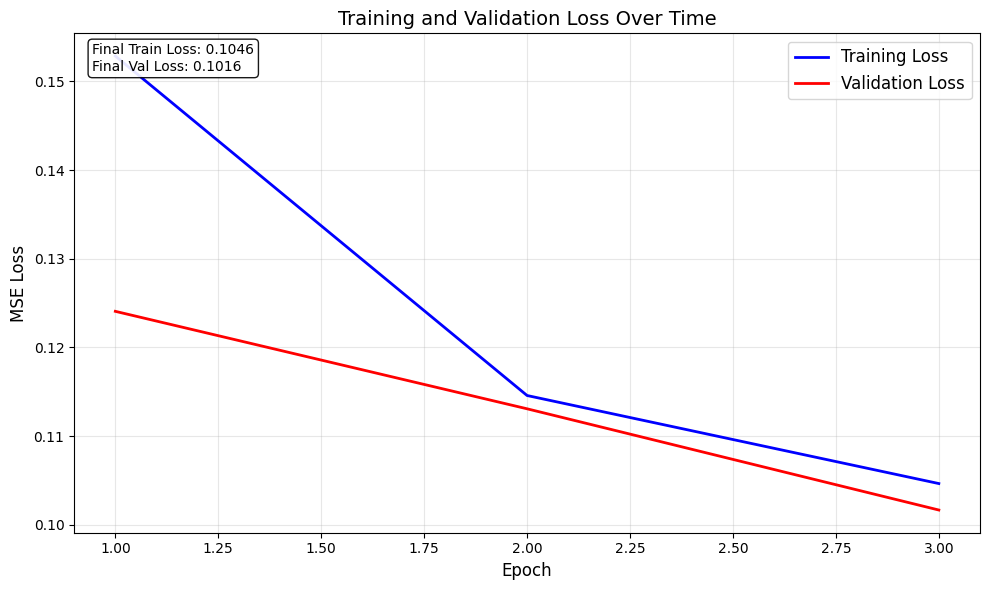

Training Summary:
	Total epochs: 3
	Final training loss: 0.1046
	Final validation loss: 0.1016


In [ ]:
def plot_training_curves(train_losses, val_losses):
    if not train_losses or not val_losses:
        print("No loss data available to plot. Train a new model to see loss curves.")
        return
    
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    
    plt.title('Training and Validation Loss Over Time', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    
    stats_text = f'Final Train Loss: {final_train_loss:.4f}\nFinal Val Loss: {final_val_loss:.4f}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
             fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total epochs: {len(train_losses)}")
    print(f"Final training loss: {final_train_loss:.4f}")
    print(f"Final validation loss: {final_val_loss:.4f}")

plot_training_curves(train_losses, val_losses)

## Validation

Since the model is not actually expected to perform well, validation is kept minimal.  
Seeing that the model does predict reasonable values, which are better than random should be enough for this toy implementation.

### Mean Absolute Error (MAE)

Dataset created with 13147 sequences
Creating prediction comparison table...

10M_U_COMPONENT_OF_WIND:
 Node     Lat     Lon True (actual) Pred (actual) Error (norm)
   13 -87.19°  73.12°          2.79          3.69       0.1782
  458 -47.81°  56.25°          8.12          7.56       0.1099
  795 -19.69° 151.88°         -2.55         -1.13       0.2814
  806 -19.69° 213.75°         -5.52         -8.41       0.5719
  902  -8.44°  33.75°          0.17          0.66       0.0965
 1082   2.81° 326.25°         -3.08         -4.68       0.3177
 1094   8.44°  33.75°         -0.51         -2.44       0.3814
 1781  64.69° 298.12°         -2.88         -1.17       0.3394

10M_V_COMPONENT_OF_WIND:
 Node     Lat     Lon True (actual) Pred (actual) Error (norm)
   13 -87.19°  73.12°         -4.05         -4.49       0.1037
  458 -47.81°  56.25°        -10.94        -13.10       0.5021
  795 -19.69° 151.88°         -0.57          1.12       0.3938
  806 -19.69° 213.75°          0.71          2.17   

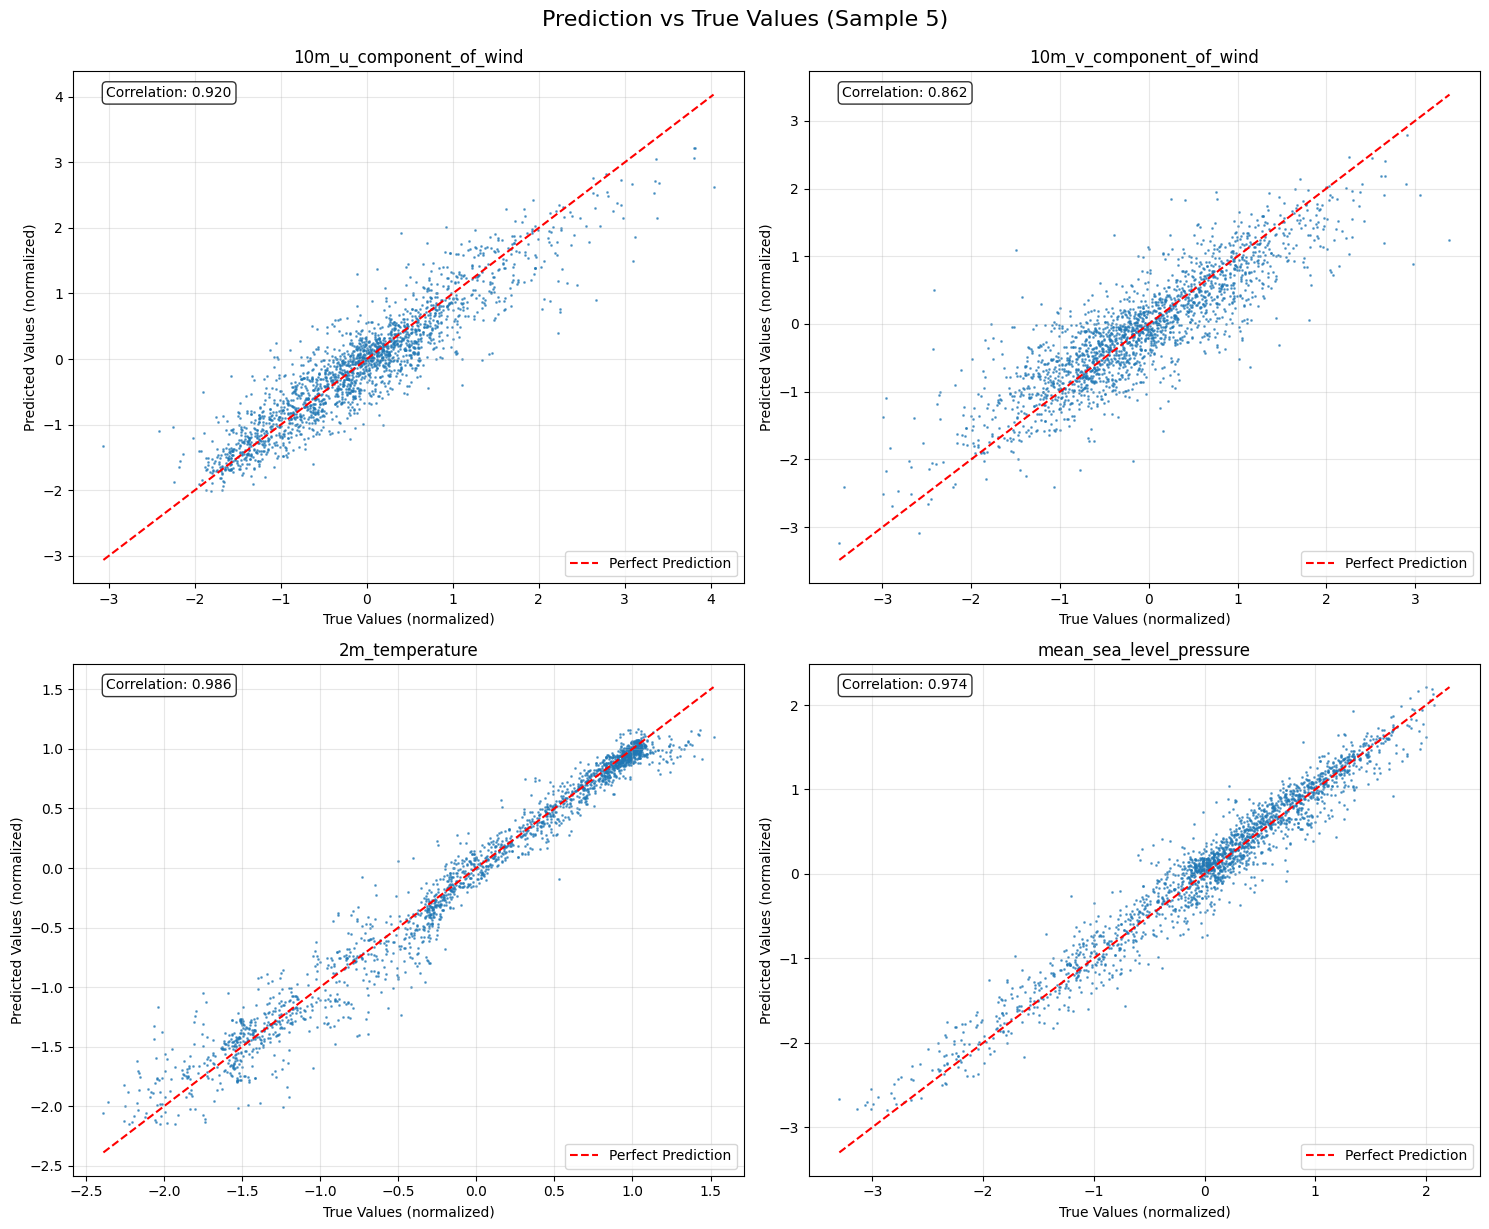

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_predictions(model, graph_structure, dataset, norm_stats, sample_idx=0, num_nodes_to_show=10):
    sample = dataset[sample_idx]
    
    # move to device and get prediction
    device = next(model.parameters()).device
    x = sample['x'].to(device)
    edge_index = sample['edge_index'].to(device)
    
    model.eval()
    with torch.no_grad():
        prediction = model(x, edge_index)
    
    # move back to CPU
    x_cpu = x.cpu()
    y_true = sample['y'].cpu()
    y_pred = prediction.cpu()
    
    print("=" * 100)
    
    feature_names = []
    for var in Config.SURFACE_VARS:
        feature_names.append(f"{var}")
    for var in Config.ATMOSPHERIC_VARS:
        for level in Config.PRESSURE_LEVELS:
            feature_names.append(f"{var}_{level}hPa")
    
    # sample some nodes
    node_indices = np.random.choice(len(x_cpu), min(num_nodes_to_show, len(x_cpu)), replace=False)
    node_indices = sorted(node_indices)
    
    data_rows = []
    for node_idx in node_indices:
        lat = graph_structure.positions[node_idx, 0].item()
        lon = graph_structure.positions[node_idx, 1].item()
        
        for feat_idx, feat_name in enumerate(feature_names):
            input_val = x_cpu[node_idx, feat_idx].item()
            true_val = y_true[node_idx, feat_idx].item()
            pred_val = y_pred[node_idx, feat_idx].item()
            
            # denormalize values
            if norm_stats:
                if feat_name in norm_stats:
                    mean = norm_stats[feat_name]['mean']
                    std = norm_stats[feat_name]['std']
                    input_denorm = input_val * std + mean
                    true_denorm = true_val * std + mean
                    pred_denorm = pred_val * std + mean
                else:
                    input_denorm = input_val
                    true_denorm = true_val
                    pred_denorm = pred_val
            
            error = abs(pred_val - true_val)
            
            data_rows.append({
                'Node': node_idx,
                'Lat': f"{lat:.2f}°",
                'Lon': f"{lon:.2f}°", 
                'Feature': feat_name,
                'Input (norm)': f"{input_val:.4f}",
                'True (norm)': f"{true_val:.4f}",
                'Pred (norm)': f"{pred_val:.4f}",
                'Error (norm)': f"{error:.4f}",
                'Input (actual)': f"{input_denorm:.2f}",
                'True (actual)': f"{true_denorm:.2f}",
                'Pred (actual)': f"{pred_denorm:.2f}"
            })
    
    # ---------------------------------------------------------------
    # convert to DataFrame and display
    df = pd.DataFrame(data_rows)
    
    for feature in feature_names[:4]:
        feature_df = df[df['Feature'] == feature].copy()
        if not feature_df.empty:
            print(f"\n{feature.upper()}:")
            print(feature_df[['Node', 'Lat', 'Lon', 'True (actual)', 'Pred (actual)', 'Error (norm)']].to_string(index=False))
    
    # calculate overall statistics
    all_errors = [float(row['Error (norm)']) for row in data_rows]
    all_true = [float(row['True (norm)']) for row in data_rows]
    all_pred = [float(row['Pred (norm)']) for row in data_rows]
    
    mae = np.mean(all_errors)
    mse = np.mean([(t-p)**2 for t, p in zip(all_true, all_pred)])
    rmse = np.sqrt(mse)
    
    print(f"\nOVERALL STATISTICS:")
    print(f"Mean Absolute Error (normalized): {mae:.4f}")
    print(f"Root Mean Square Error (normalized): {rmse:.4f}")
    
    return df

def plot_prediction_comparison(model, graph_structure, dataset, norm_stats, sample_idx=0):
    sample = dataset[sample_idx]
    device = next(model.parameters()).device
    x = sample['x'].to(device)
    edge_index = sample['edge_index'].to(device)
    
    model.eval()
    with torch.no_grad():
        prediction = model(x, edge_index)
    
    y_true = sample['y'].cpu().numpy()
    y_pred = prediction.cpu().numpy()
    
    # create subplots for different variables
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    feature_names = []
    for var in Config.SURFACE_VARS:
        feature_names.append(var)
    for var in Config.ATMOSPHERIC_VARS:
        for level in Config.PRESSURE_LEVELS:
            feature_names.append(f"{var}_{level}")
    
    # plot first 4 features
    for i, feat_name in enumerate(feature_names[:4]):
        ax = axes[i]
        
        true_vals = y_true[:, i]
        pred_vals = y_pred[:, i]
        
        # scatter plot: predicted vs actual
        ax.scatter(true_vals, pred_vals, alpha=0.6, s=1)
        
        # perfect prediction line
        min_val, max_val = min(true_vals.min(), pred_vals.min()), max(true_vals.max(), pred_vals.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
        
        ax.set_xlabel('True Values (normalized)')
        ax.set_ylabel('Predicted Values (normalized)')
        ax.set_title(f'{feat_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # calculate R squared score
        correlation = np.corrcoef(true_vals, pred_vals)[0, 1]
        ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle(f'Prediction vs True Values (Sample {sample_idx})', y=1.02, fontsize=16)
    plt.show()

with open(Config.PROCESSED_DIR / "norm_stats.json", 'r') as f:
    norm_stats = json.load(f)
test_dataset = WeatherSequenceDataset(ds_test, graph_structure, norm_stats)

# Visualize predictions
print("Creating prediction comparison table...")
comparison_df = visualize_predictions(model, graph_structure, test_dataset, norm_stats, sample_idx=5, num_nodes_to_show=8)

print("\nCreating prediction scatter plots...")
plot_prediction_comparison(model, graph_structure, test_dataset, norm_stats, sample_idx=5)

### Heatmap: Baseline vs Actual vs Predicted

Dataset created with 13147 sequences


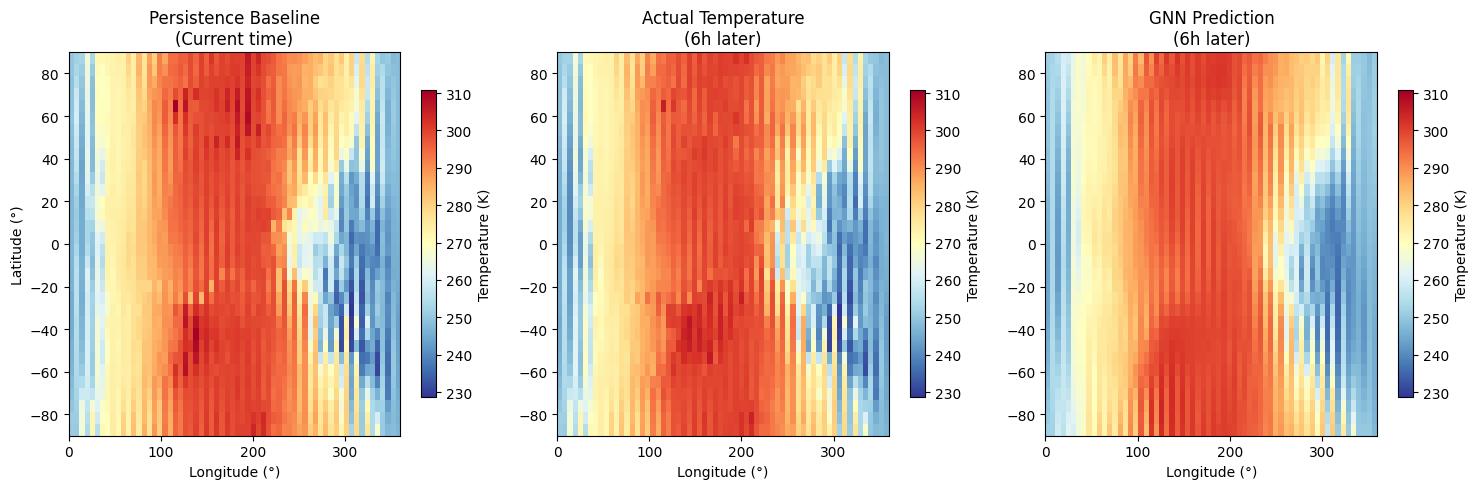

Performance Summary:
Temperature range: -44.5°C to 33.5°C
Baseline MAE: 1.277 K
Model MAE: 2.315 K
Improvement: -81.3%
	Model worse than persistence baseline


In [32]:
def visualize_temperature_predictions(model, dataset, norm_stats, sample_idx=10):
    sample = dataset[sample_idx]
    device = next(model.parameters()).device
    x = sample['x'].to(device)
    edge_index = sample['edge_index'].to(device)
    
    model.eval()
    with torch.no_grad():
        prediction = model(x, edge_index)
    
    # extract 2m temperature data
    feature_names = []
    for var in Config.SURFACE_VARS:
        feature_names.append(var)
    for var in Config.ATMOSPHERIC_VARS:
        for level in Config.PRESSURE_LEVELS:
            feature_names.append(f"{var}_{level}")
    
    temp_idx = feature_names.index('2m_temperature')
    
    input_temp = sample['x'][:, temp_idx].cpu().numpy()
    true_temp = sample['y'][:, temp_idx].cpu().numpy()
    pred_temp = prediction[:, temp_idx].cpu().numpy()
    
    # denormalize
    if '2m_temperature' in norm_stats:
        mean = norm_stats['2m_temperature']['mean']
        std = norm_stats['2m_temperature']['std']
        input_temp = input_temp * std + mean
        true_temp = true_temp * std + mean
        pred_temp = pred_temp * std + mean
    
    # reshape to grid (32 lat x 64 lon)
    n_lat, n_lon = len(ds_train.latitude), len(ds_train.longitude)
    input_grid = input_temp.reshape(n_lon, n_lat).T
    true_grid = true_temp.reshape(n_lon, n_lat).T
    pred_grid = pred_temp.reshape(n_lon, n_lat).T
    
    # create simple comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # common temperature scale
    vmin = min(input_grid.min(), true_grid.min(), pred_grid.min())
    vmax = max(input_grid.max(), true_grid.max(), pred_grid.max())
    
    # plot all three
    titles = ['Persistence Baseline\n(Current time)', 'Actual Temperature\n(6h later)', 'GNN Prediction\n(6h later)']
    grids = [input_grid, true_grid, pred_grid]
    
    for i, (ax, grid, title) in enumerate(zip(axes, grids, titles)):
        im = ax.imshow(grid, cmap='RdYlBu_r', vmin=vmin, vmax=vmax, 
                       extent=[0, 360, -90, 90], aspect='auto')
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('Longitude (°)')
        if i == 0:
            ax.set_ylabel('Latitude (°)')
        
        # add colorbar
        cbar = plt.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label('Temperature (K)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # calculate and print simple statistics
    persistence_error = np.abs(true_grid - input_grid).mean()
    model_error = np.abs(true_grid - pred_grid).mean()
    improvement = ((persistence_error - model_error) / persistence_error) * 100
    
    print(f"Performance Summary:")
    print(f"Temperature range: {true_temp.min()-273.15:.1f}°C to {true_temp.max()-273.15:.1f}°C")
    print(f"Baseline MAE: {persistence_error:.3f} K")
    print(f"Model MAE: {model_error:.3f} K")
    print(f"Improvement: {improvement:+.1f}%")
    
    if improvement > 0:
        print(f"\tModel beats persistence baseline!")
    else:
        print(f"\tModel worse than persistence baseline")

with open(Config.PROCESSED_DIR / "norm_stats.json", 'r') as f:
    norm_stats = json.load(f)
test_dataset = WeatherSequenceDataset(ds_test, graph_structure, norm_stats)

visualize_temperature_predictions(model, test_dataset, norm_stats, sample_idx=10)